In [1]:
import json
from pathlib import Path
import numpy as np
import seaborn as sns
from pydantic import BaseModel
from mosaic_dataset import MosaicDataModule, Bucket
from matplotlib import pyplot as plt


/data/training/pypoetry/virtualenvs/multipage-classifier-xptqA-4L-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
class Page(BaseModel):
    src_page: int
    dst_page:int 

class Document(BaseModel):
    doc_class: str
    pages: list[Page]

def get_document_stacks_from_bucket(bucket: Bucket, path: str):
    stacks: list[list[Document]] = []
    with (Path(path) / f"{bucket.value}.txt").open("r") as file:
        inventory = [Path(line.rstrip()) for line in file.readlines()]
    
    for idx in range(len(inventory)):
        sample_path = path / inventory[idx]

        document = json.loads((sample_path / "document.json").read_bytes().decode())

        best_candidate = max(document["prediction"]["candidates"], key=lambda c: c["score"])
        assert len(best_candidate["documents"]) > 0 and len(document["pages"]) > 0


        document_stack = []
        for doc_id, predicted_doc in enumerate(best_candidate["documents"]):
            class_identifier = str(
                Path(predicted_doc["documentClass"]).relative_to(document["documentClass"])
            )
            pages = []
            if "pages" not in predicted_doc or len(predicted_doc["pages"]) == 0:
                pages = [Page(src_page=i, dst_page=i) for i in range(len(document["pages"]))]
            else:
                for dst_page, page in enumerate(predicted_doc["pages"]):
                    src_page = page.get("sourcePage", 0) # NOTE the default value is 0
                    pages.append(Page(src_page=src_page, dst_page=dst_page) )
            document_stack.append(Document(doc_class=class_identifier, pages = pages))
        stacks.append(document_stack)
    return stacks

# General

In [21]:
bucket = Bucket.Testing
path = "/data/training/master_thesis/datasets/2023-05-23"



In [22]:
stacks = get_document_stacks_from_bucket(bucket, path)

sns.set_theme(style="darkgrid")
sns.set_theme(palette="light:m_r")


# Training, Validation, Test

In [5]:
train = get_document_stacks_from_bucket(Bucket.Training, path)
train_n_stacks = len(train)
train_n_docs = sum([len(stack) for stack in train])
train_n_pages = sum([len(doc.pages) for stack in train for doc in stack])

val = get_document_stacks_from_bucket(Bucket.Validation, path)
val_n_stacks = len(val)
val_n_docs = sum([len(stack) for stack in val])
val_n_pages = sum([len(doc.pages) for stack in val for doc in stack])

test = get_document_stacks_from_bucket(Bucket.Testing, path)
test_n_stacks = len(test)
test_n_docs = sum([len(stack) for stack in test])
test_n_pages = sum([len(doc.pages) for stack in test for doc in stack])

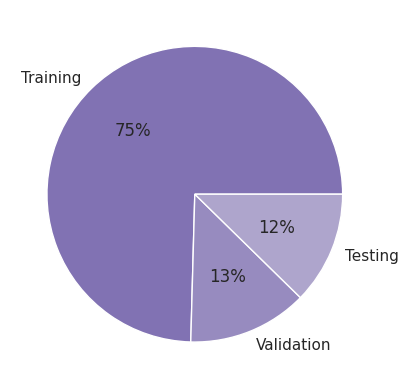

In [6]:
plt.pie([train_n_stacks, val_n_stacks, test_n_stacks], labels=["Training", "Validation", "Testing"],  autopct='%.0f%%') 
plt.show()

# Doc & Page Counts

In [7]:
print(f"________________________________________________")
print(f"Bucket {bucket.value}")
print(f"________________________________________________")

print(f"Number of doc stacks: {len(stacks)}")
docs_per_stack = [len(stack) for stack in stacks]
print(f"Number of docs:       {(sum(docs_per_stack))}")
pages_per_doc = [len(doc.pages) for stack in stacks for doc in stack]
pages_per_stack = [sum([len(doc.pages) for doc in stack]) for stack in stacks ]
print(f"Number of pages:      {sum(pages_per_stack)}")

print(f"________________________________________________")
print(f"Max docs per stack:  {max(docs_per_stack)}")
print(f"Max pages per stack: {max(pages_per_stack)}")
print(f"Max pages per doc:   {max(pages_per_doc)}")



print(f"________________________________________________")
print(f"Avg of doc count per stack:  {sum(docs_per_stack) / len(stacks)}")
print(f"Avg of page count per stack: {sum(pages_per_stack) / len(stacks)}")
print(f"Avg of page count per doc:   {sum(pages_per_stack) / sum(docs_per_stack)}")
print(f"________________________________________________")
print()


________________________________________________
Bucket training
________________________________________________
Number of doc stacks: 5605
Number of docs:       13914
Number of pages:      32486
________________________________________________
Max docs per stack:  32
Max pages per stack: 121
Max pages per doc:   76
________________________________________________
Avg of doc count per stack:  2.4824264049955396
Avg of page count per stack: 5.795896520963425
Avg of page count per doc:   2.334770734512002
________________________________________________



Text(0.5, 1.0, 'Dokumente pro Stapel')

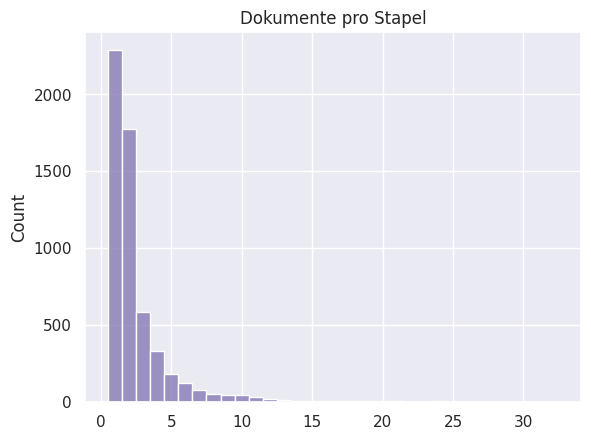

In [8]:
sns.histplot(docs_per_stack, discrete=True).set_title('Dokumente pro Stapel')

Text(0.5, 1.0, 'Seiten pro Stapel')

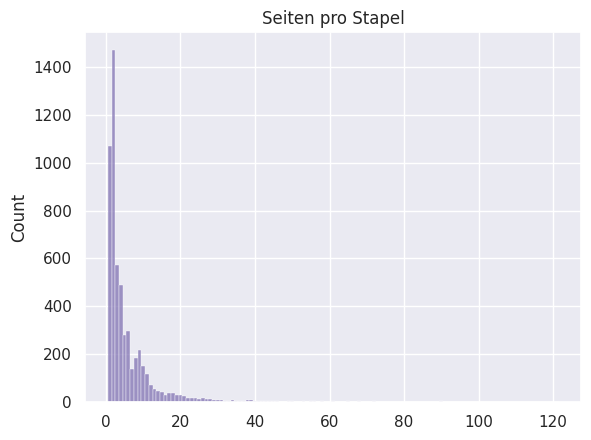

In [9]:
sns.histplot(pages_per_stack, discrete=True).set_title('Seiten pro Stapel')

Text(0.5, 1.0, 'Seiten pro Dokument')

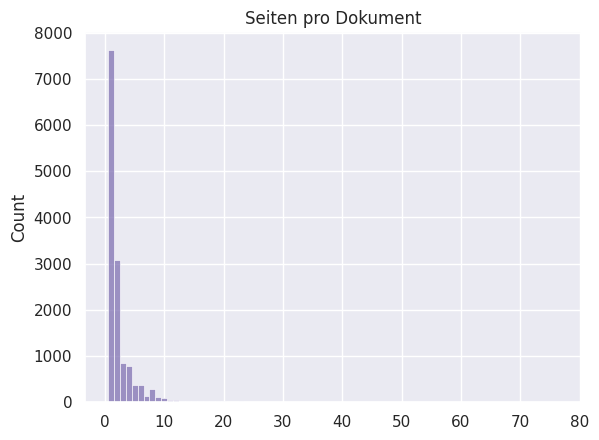

In [10]:
sns.histplot(pages_per_doc, discrete=True).set_title('Seiten pro Dokument')

# Class Counts

In [11]:
unique_classes =[]
for stack in stacks:
    for doc in stack:
        if doc.doc_class not in unique_classes:
            unique_classes.append(doc.doc_class)

unique_classes = sorted(unique_classes)

class_mapping = {str(label): idx for idx, label in enumerate(unique_classes)}


In [12]:
from collections import defaultdict


class_counts = defaultdict(lambda: 0)
classes = []
for stack in stacks:
    for doc in stack:
        class_id = class_mapping[doc.doc_class]
        classes.append(class_id)
        class_counts[class_id] += 1

In [23]:
for stack in stacks:
    for doc in stack:
        if doc.doc_class not in unique_classes:
            unique_classes.append(doc.doc_class)

unique_classes = sorted(unique_classes)

In [27]:
print(unique_classes)
print(len(unique_classes))
import json
json.dump(unique_classes, open("/data/training/master_thesis/datasets/bzuf_classes.json", "w+"))

['abmeldung', 'abmeldung.fruehfoerderung', 'abmeldung.heilpaedagogische_tagesstaette', 'abschlussbericht', 'adressnderung', 'aenderungsmeldung.auszug', 'aenderungsmeldung.krankenhausaufenthalt', 'aerztliche_unterlagen', 'aerztliche_unterlagen.kinder_und_jugendpsychiatrie', 'aerztliche_unterlagen.sozialpaediatrisches_zentrum', 'aktenvermerk', 'amtshilfe.ersuchen', 'amtshilfe.ruecklauf', 'anhoerung.stellungnahme', 'anmeldeblatt.sve', 'anschreiben', 'antrag.aufnahmeanzeige_dauerpflege', 'antrag.aufnahmeanzeige_kurzzeitpflege', 'antrag.auslaenderrechtlicher_status', 'antrag.ausweiskopie', 'antrag.falluebernahme_vom_jugendamt', 'antrag.folgeantrag_grundsicherung_hlu', 'antrag.formblattantrag', 'antrag.formblattantrag.ambulant_betreutes_wohnen', 'antrag.formblattantrag.ambulant_unterstuetztes_wohnen', 'antrag.formblattantrag.besondere_wohnform', 'antrag.formblattantrag.betreutes_wohnen_in_familien', 'antrag.formblattantrag.dauerwohnheim', 'antrag.formblattantrag.einzelintegration', 'antrag.f

In [14]:
print(f"________________________________________________")
print(f"Bucket {bucket.value}")
print(f"________________________________________________")

print(f"Number of classes: {len(class_counts)}")
print(f"Min number of class samples: {min(class_counts.values())}")
print(f"Max number of class samples: {max(class_counts.values())}")



________________________________________________
Bucket training
________________________________________________
Number of classes: 354
Min number of class samples: 1
Max number of class samples: 1878


Text(0.5, 1.0, 'Klassenhistogram')

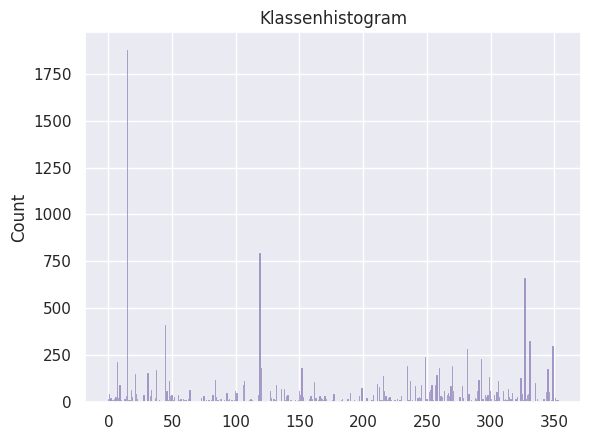

In [15]:
sns.histplot(classes, discrete=True).set_title('Klassenhistogram')
